In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from concise.preprocessing import encodeDNA, encodeSplines
from concise.utils.helper import read_json
from concise.hyopt import CMongoTrials, get_data, get_model

import data
import model
from helper import *
DIR_ROOT = "/s/project/deepcis/encode/eclip/"
#DIR_ROOT = "/home/avsec/projects-work/deepcis/data/encode/eclip/"
DB_NAME = "RBP__Eclip"
HOST = "localhost"

%matplotlib inline  
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

Using TensorFlow backend.


In [2]:
rbp_name = "PUM2"

In [3]:
# TODO - define 3 different data splits
# 1 existing, 2 new
data_splits = {
    "1_default_split": {"valid_chr":[18, 19, 20, 21, 22, "X"], 
                       "test_chr": [1, 2, 3]},
    "2_split":  {"valid_chr": [1,3], 
                 "test_chr": [2, 4, 6, 8, 10]},
    "3_split": {"valid_chr": [2, 3, 4],
                "test_chr": [5, 6, 7, 8, 9, 10]}
}
split = data_splits["1_default_split"]

In [4]:
## get existing top hyper-parameters
params = {}
trials = CMongoTrials(DB_NAME, "DeepNN_scalar_position_gam_" + rbp_name, HOST)
params["gam_best"] = trials.get_param(trials.best_trial_tid()).to_dict()
trials = CMongoTrials(DB_NAME, "DeepNN_scalar_position_relu_" + rbp_name, HOST)
params["relu_best"] = trials.get_param(trials.best_trial_tid()).to_dict()

In [5]:
params

{'gam_best': {'data': {'n_bases': 10,
   'pos_as_track': False,
   'pos_class_weight': 1.0,
   'rbp_name': 'PUM2'},
  'fit': {'batch_size': 128,
   'early_stop_monitor': 'val_loss',
   'epochs': 150,
   'patience': 5,
   'use_weight': False},
  'model': {'activation': 'relu',
   'dropout_rate': 0.5539060457782069,
   'external_pos': {'as_track': False,
    'scale': 'log',
    'type': 'gam',
    'units': 1},
   'filters': 16,
   'internal_pos': {'name': 'strided_maxpool', 'pool_size': 4},
   'lr': 0.0037294206685898517,
   'use_batchnorm': True},
  'shared': {'kernel_size': 10}},
 'relu_best': {'data': {'n_bases': 20,
   'pos_as_track': False,
   'pos_class_weight': 1.0,
   'rbp_name': 'PUM2'},
  'fit': {'batch_size': 128,
   'early_stop_monitor': 'val_loss',
   'epochs': 150,
   'patience': 5,
   'use_weight': False},
  'model': {'activation': 'relu',
   'dropout_rate': 0.22863681664735946,
   'external_pos': {'as_track': False,
    'scale': 'log',
    'type': 'relu',
    'units': 1},


In [8]:
from keras.callbacks import EarlyStopping

In [ ]:
dtm_list = []
for k_split in data_splits.keys():
    for k_param in params.keys():
        for ext_pos in ["gam","relu"]:
            print("{param}, {split}".format(param=k_param, split=k_split))
            param = params[k_param]
            param["model"]["external_pos"]["type"] = ext_pos
            
            split = data_splits[k_split]
            param["data"] = {**param["data"], **split}
            print("get data...")
            train, valid, test = get_data(data.data, param)
            print("get model...")
            m = get_model(model.model, train, param)
            m.fit(train[0], train[1].astype(int), epochs=150, batch_size=128,
                  validation_data=(valid[0], valid[1].astype(int)),
                  callbacks=[EarlyStopping(patience=5)])
            print("get_metrics...")
            dtm = metrics_dt(m, {"train": (train[0], train[1]), 
                        "valid": (valid[0], valid[1]), 
                        "test": (test[0], test[1])})
            dtm["param"] = k_param
            dtm["split"] = k_split
            dtm["ext_pos"] = ext_pos
            dtm_list.append(dtm)
            print("done!")
dtm_all = pd.concat(dtm_list)
dtm_all.to_csv(DIR_ROOT + "processed/data_split/performances.csv")

relu_best, 1_default_split
get data...
WARNING, x.max() > end for some elements. Truncating them to end: x[x > end] = end
WARNING, x.max() > end for some elements. Truncating them to end: x[x > end] = end
WARNING, x.max() > end for some elements. Truncating them to end: x[x > end] = end
WARNING, x.max() > end for some elements. Truncating them to end: x[x > end] = end
WARNING, x.max() > end for some elements. Truncating them to end: x[x > end] = end
WARNING, x.max() > end for some elements. Truncating them to end: x[x > end] = end
get model...
Train on 17713 samples, validate on 4881 samples
Epoch 1/150
17713/17713 [==============================] - 16s - loss: 0.4089 - acc: 0.8236 - val_loss: 0.4036 - val_acc: 0.8134
Epoch 2/150
17713/17713 [==============================] - 15s - loss: 0.2964 - acc: 0.8897 - val_loss: 0.8154 - val_acc: 0.5532
Epoch 3/150
17713/17713 [==============================] - 15s - loss: 0.2749 - acc: 0.8973 - val_loss: 0.3382 - val_acc: 0.8844
Epoch 4/150
17

In [5]:
dtm_all = pd.read_csv(DIR_ROOT + "processed/data_split/performances.csv")

In [6]:
# TODO - make the performance plot
dtm_all 

,Unnamed: 0,dataset,loss,acc,auc,auprc,param,split,ext_pos
0,0,train,0.2161,0.9210,0.9501,0.8802,gam_best,3_split,gam
1,1,valid,0.2518,0.9086,0.9269,0.8365,gam_best,3_split,gam
2,2,test,0.2446,0.9067,0.9349,0.8491,gam_best,3_split,gam
...,...,...,...,...,...,...,...,...,...
33,0,train,0.2220,0.9159,0.9539,0.8843,relu_best,2_split,relu
34,1,valid,0.2690,0.8961,0.9290,0.8422,relu_best,2_split,relu
35,2,test,0.2716,0.8953,0.9270,0.8393,relu_best,2_split,relu


In [11]:
dtm_all["split_param_extpos"] = dtm_all.split.str.cat(dtm_all.param, sep="-").str.cat(dtm_all.ext_pos, sep="-")

In [12]:
dir(dtm_all.split.str.cat(dtm_all.param, sep="-"))

['T',
 '_AXIS_ALIASES',
 '_AXIS_IALIASES',
 '_AXIS_LEN',
 '_AXIS_NAMES',
 '_AXIS_NUMBERS',
 '_AXIS_ORDERS',
 '_AXIS_REVERSED',
 '_AXIS_SLICEMAP',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_prepare__',
 '__array_priority__',
 '__array_wrap__',
 '__bool__',
 '__bytes__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__int__',
 '__invert__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__le__',
 '__len__',
 '__long__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rmod__',
 '__rmul_

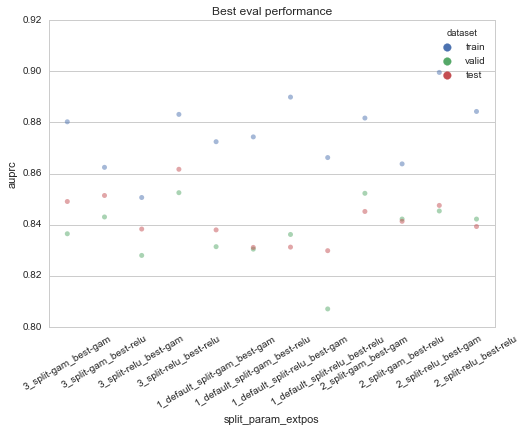

In [13]:
g = sns.stripplot(x = "split_param_extpos", hue="dataset", 
                  y = "auprc", alpha =0.5,
                  data=dtm_all)
plt.xticks(rotation=30)
plt.title("Best eval performance")